In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scvelo as scv
import FRED
if torch.__version__[:4] == '1.14': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# sns.set_theme()
scv.set_figure_params('scvelo')  # for beautified visualization
%load_ext autoreload
%autoreload 2

Using device cpu


# 05g Single Cell Dataset Benchmarker with UMAP
> Run FRED on a specified single cell dataset, using UMAP embeddings

This is set up for the popular library `papermill`, which can parameterize and execute notebooks. 

First, we set the notebook-wide parameters, then run the cells. Papermill will create copies of the notebook with each parameter configuration given.

In [ ]:
notebook = "05c Single Cell Dataset Benchmarker"
dataset_name = "pancreas"
sigma = 'automatic'
flow_strength = 1
smoothness_weight = 0
flow_neighbor_loss_weight = 1
contrastive_flow_loss_weight = 1
contrastive_loss_weight = 0
diffdist_weight = 10
num_neighbors = 10

# Set Up

In [ ]:
# Load single cell dataset from scvelo and get associated information
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo, rnavelo_pcs
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
import scvelo as scv
import os
from pathlib import Path

# choose correct dataset
Xpath = f"../../data/{dataset_name}/processed/X.txt"
if os.path.exists(Xpath):
    X = np.loadtxt(Xpath)
    flow = np.loadtxt(f"../../data/{dataset_name}/processed/flow.txt")
    labels = np.loadtxt(f"../../data/{dataset_name}/processed/labels.txt")
    latent_time = np.loadtxt(f"../../data/{dataset_name}/processed/latent_time.txt")
else:
    if dataset_name == "bone marrow":
        adata = scv.datasets.bonemarrow()
    elif dataset_name == "dentategyrus":
        adata = scv.datasets.dentategyrus()
    elif dataset_name == "pancreas":
        adata = scv.datasets.pancreas()
    elif dataset_name == "dentategyrus_lamanno":
        adata = scv.datasets.dentategyrus_lamanno()
    print("processing data with pcs")
    X, flow, labels, n_pcs = rnavelo_pcs(adata)
    # dynamical recovery
    scv.tl.recover_dynamics(adata, n_jobs=7)
    scv.tl.latent_time(adata)
    latent_time = adata.obs['latent_time'].to_numpy()
    # save the processed data to np txt files for ready loading in the future
    Path(f"data/{dataset_name}/processed").mkdir(parents = True,exist_ok=True)
    np.savetxt(f"data/{dataset_name}/processed/X.txt",X)
    np.savetxt(f"data/{dataset_name}/processed/flow.txt",flow)
    np.savetxt(f"data/{dataset_name}/processed/labels.txt",labels)
    np.savetxt(f"data/{dataset_name}/processed/latent_time.txt",latent_time)


Set sigma =  8.403331
Computing UMAP


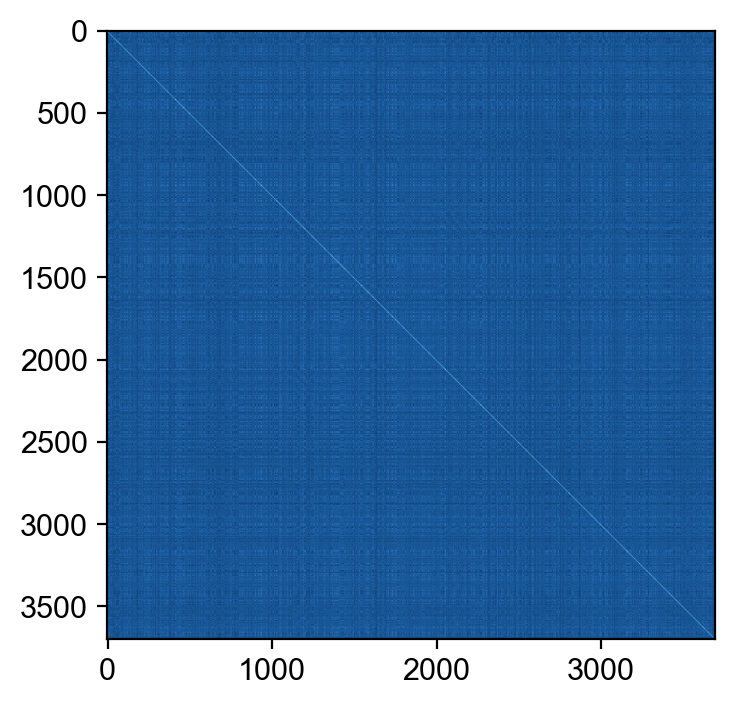

In [ ]:
# build dataset
ds = ManifoldWithVectorField(X, flow, labels, sigma=sigma, nbhd_strategy="flow neighbors", n_neighbors=num_neighbors, flow_strength = flow_strength, prior_embedding="UMAP")
dataloader = DataLoader(ds, batch_size=None, shuffle=True)

## Set up the model

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points, Trainer
title = notebook.replace('.ipynb','')
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[X.shape[1], 20, 10, 5, 2],
            device=device,
            sigma=5,
            flow_strength=1,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": 0,
            "distance regularization": diffdist_weight,
            "kld": 0,
            "smoothness": smoothness_weight,
            "flow neighbor loss": flow_neighbor_loss_weight,
            "contrastive flow loss": contrastive_flow_loss_weight,
            "contrastive loss":contrastive_loss_weight,
        }
visualization_functions = [
    save_embedding_visualization # just save these, for use in gif making. No visualizations otherwise, to keep it tidy.
]
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = title)

In [ ]:
#papermill_description=FittingFRED
FREDtrainer.fit(dataloader, n_epochs=100)

  1%|          | 1/100 [00:11<18:18, 11.10s/it]

{'distance regularization': tensor(0.3491, grad_fn=<DivBackward0>), 'flow neighbor loss': tensor(2.2414, grad_fn=<PowBackward0>), 'contrastive flow loss': tensor(0.0003, grad_fn=<MulBackward0>)}


 11%|█         | 11/100 [01:59<16:08, 10.88s/it]

{'distance regularization': tensor(0.1432, grad_fn=<DivBackward0>), 'flow neighbor loss': tensor(2.7179, grad_fn=<PowBackward0>), 'contrastive flow loss': tensor(0.0007, grad_fn=<MulBackward0>)}


 21%|██        | 21/100 [03:48<14:26, 10.97s/it]

{'distance regularization': tensor(0.1950, grad_fn=<DivBackward0>), 'flow neighbor loss': tensor(3.2229, grad_fn=<PowBackward0>), 'contrastive flow loss': tensor(0.0007, grad_fn=<MulBackward0>)}


 31%|███       | 31/100 [05:39<12:49, 11.15s/it]

{'distance regularization': tensor(0.0825, grad_fn=<DivBackward0>), 'flow neighbor loss': tensor(0.9808, grad_fn=<PowBackward0>), 'contrastive flow loss': tensor(0.0004, grad_fn=<MulBackward0>)}


 41%|████      | 41/100 [07:28<10:50, 11.03s/it]

{'distance regularization': tensor(0.1156, grad_fn=<DivBackward0>), 'flow neighbor loss': tensor(0.7503, grad_fn=<PowBackward0>), 'contrastive flow loss': tensor(0.0008, grad_fn=<MulBackward0>)}


 51%|█████     | 51/100 [09:19<09:02, 11.07s/it]

{'distance regularization': tensor(0.1894, grad_fn=<DivBackward0>), 'flow neighbor loss': tensor(3.4439, grad_fn=<PowBackward0>), 'contrastive flow loss': tensor(0.0007, grad_fn=<MulBackward0>)}


 61%|██████    | 61/100 [11:05<06:55, 10.66s/it]

{'distance regularization': tensor(0.0921, grad_fn=<DivBackward0>), 'flow neighbor loss': tensor(1.3785, grad_fn=<PowBackward0>), 'contrastive flow loss': tensor(0.0004, grad_fn=<MulBackward0>)}


 71%|███████   | 71/100 [12:53<05:13, 10.80s/it]

{'distance regularization': tensor(0.1168, grad_fn=<DivBackward0>), 'flow neighbor loss': tensor(2.5916, grad_fn=<PowBackward0>), 'contrastive flow loss': tensor(0.0008, grad_fn=<MulBackward0>)}


 81%|████████  | 81/100 [14:42<03:28, 10.97s/it]

{'distance regularization': tensor(0.1184, grad_fn=<DivBackward0>), 'flow neighbor loss': tensor(2.8737, grad_fn=<PowBackward0>), 'contrastive flow loss': tensor(0.0008, grad_fn=<MulBackward0>)}


 91%|█████████ | 91/100 [16:23<01:31, 10.18s/it]

{'distance regularization': tensor(0.0883, grad_fn=<DivBackward0>), 'flow neighbor loss': tensor(2.0070, grad_fn=<PowBackward0>), 'contrastive flow loss': tensor(0.0005, grad_fn=<MulBackward0>)}


100%|██████████| 100/100 [17:49<00:00, 10.69s/it]


# Results

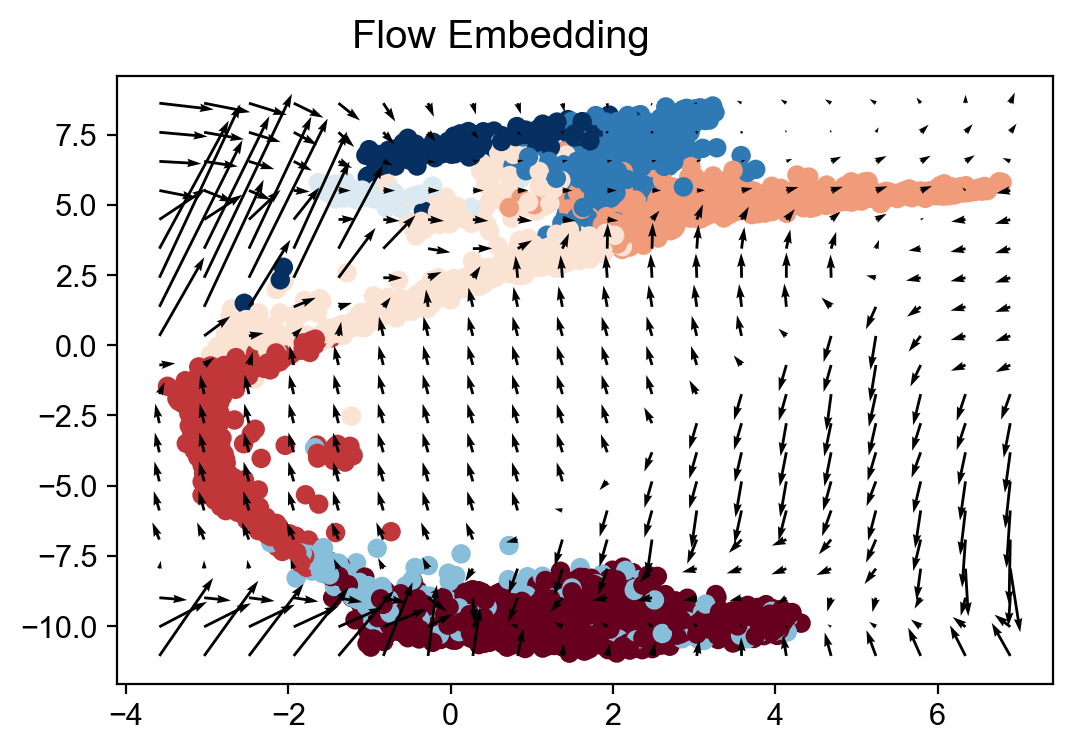

In [ ]:
FREDtrainer.visualize_embedding(use_streamlines=False)

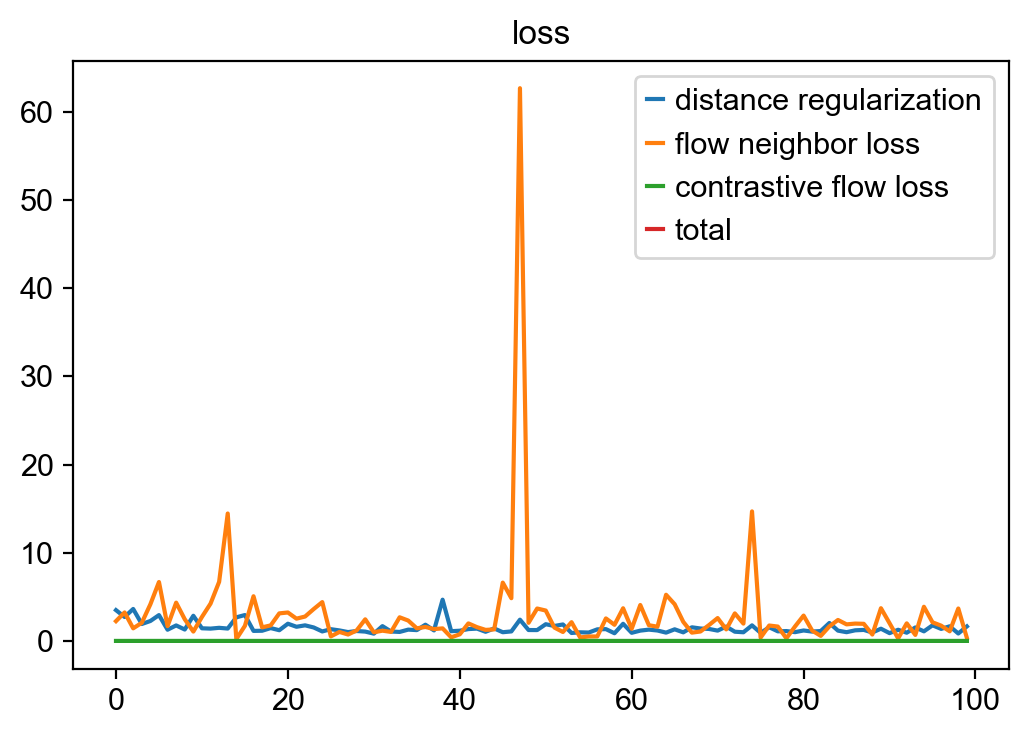

In [ ]:
FREDtrainer.visualize_loss()

In [ ]:
FREDtrainer.training_gif(duration=150)

HTML(value='<img src="data:image/gif;base64,R0lGODlhhANYAocAAP///////f//+///9P7///z///v///z//f3/+fn///j///b///…

# Qualitative analyses

We combine the embedded points with their velocities in the embedding space. 

In [ ]:
embedded_points = FREDtrainer.embedded_points.cpu().detach().numpy()
embedded_velocities = FREDtrainer.embedded_velocities.cpu().detach().numpy()

In [ ]:
# create unique identifier for notebook
import secrets
import string
alphabet = string.ascii_letters + string.digits
unid = ''.join(secrets.choice(alphabet) for i in range(20))  # for a 20-character password
spread_name = notebook + "_dataset_" + dataset_name
unid

'sVQwf6meaG886DVGItdg'

In [ ]:
from FRED.metrics import comprehensive_flow_metrics
silhouette_score, silhouete_score_with_flow, knn_score, neighbor_score, monotone_score = comprehensive_flow_metrics(
    X = X,
    flows = flow,
    labels = labels,
    embedded_points = embedded_points,
    embedded_velocities = embedded_velocities,
    time_labels = latent_time,
    spreadsheet_name=spread_name,
    unid = unid,
    flow_strength = flow_strength
)

Set sigma =  8.403331002941993


  0%|          | 0/1000 [00:00<?, ?it/s]

Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.14850718
Set sigma =  0.1

KeyboardInterrupt: 

In [ ]:
import csv
with open(f"results/{spread_name}.csv", 'a') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(
            [unid,
            sigma,
            flow_strength,
            flow_neighbor_loss_weight,
            contrastive_flow_loss_weight,
            num_neighbors,
            smoothness_weight,
            diffdist_weight,
            silhouette_score,
            silhouete_score_with_flow,
            knn_score,
            neighbor_score, 
            monotone_score,
            ])

# Save embeddings to txt files

In [ ]:
filename = f"{spread_name} - {dataset_name} - {unid}"
np.savetxt(f'embeddings/{filename} - X.txt',FREDtrainer.embedded_points.detach().cpu().numpy())
np.savetxt(f'embeddings/{filename} - V.txt',FREDtrainer.embedded_velocities.detach().cpu().numpy())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.